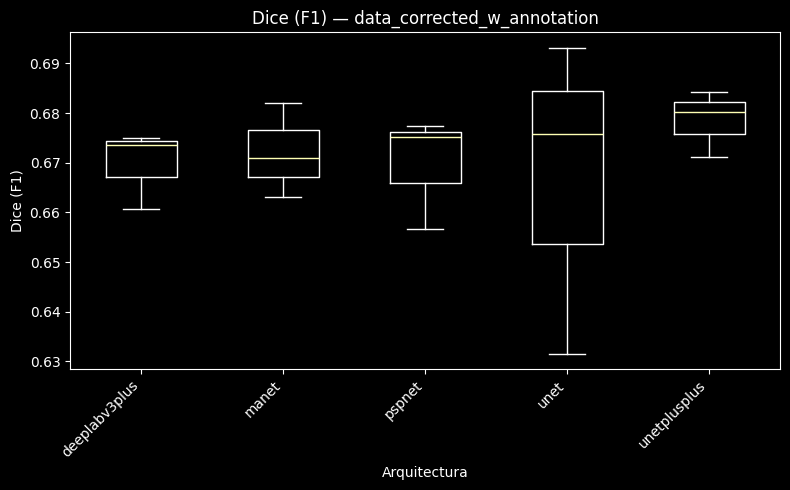

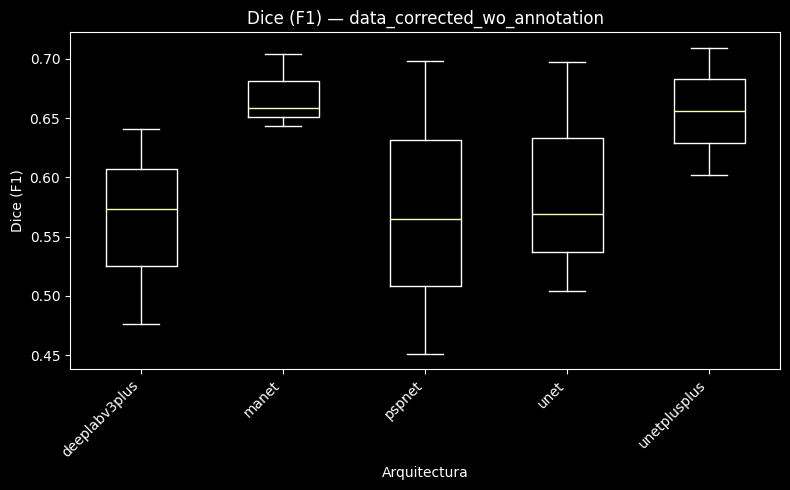

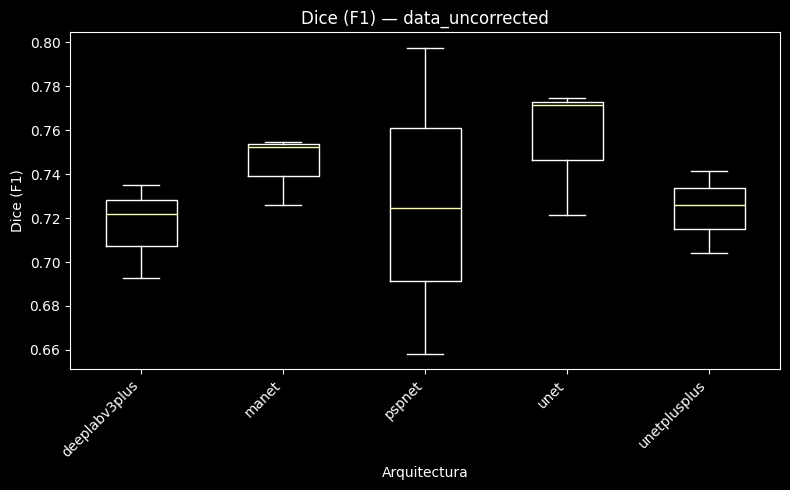

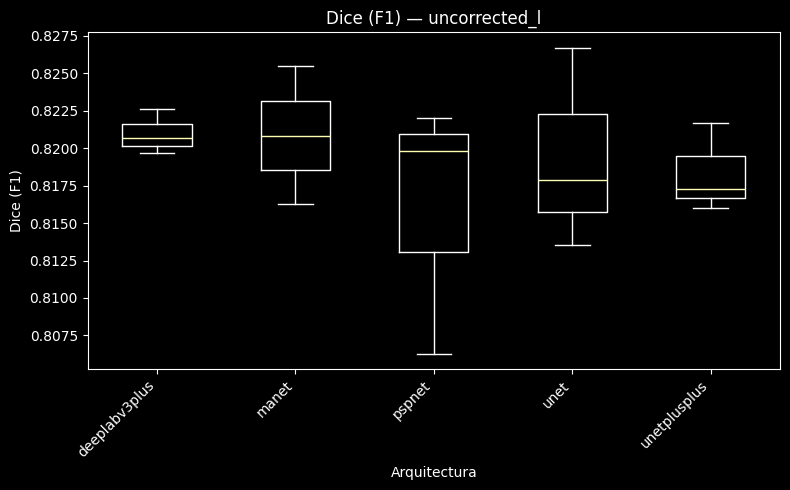

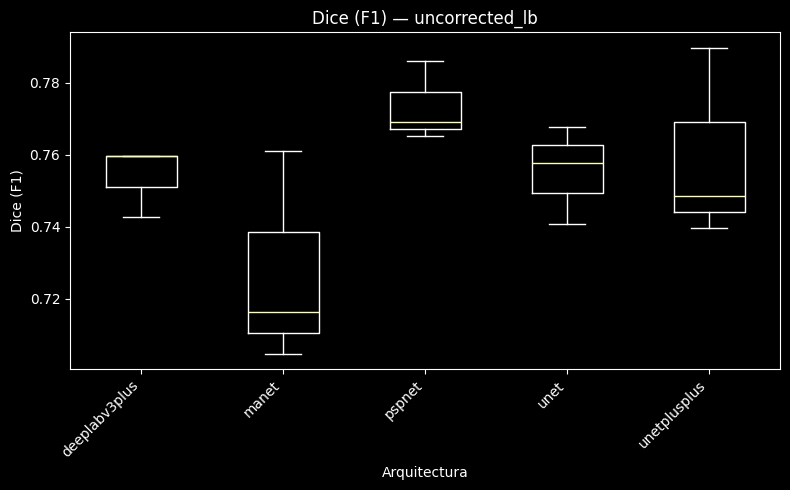

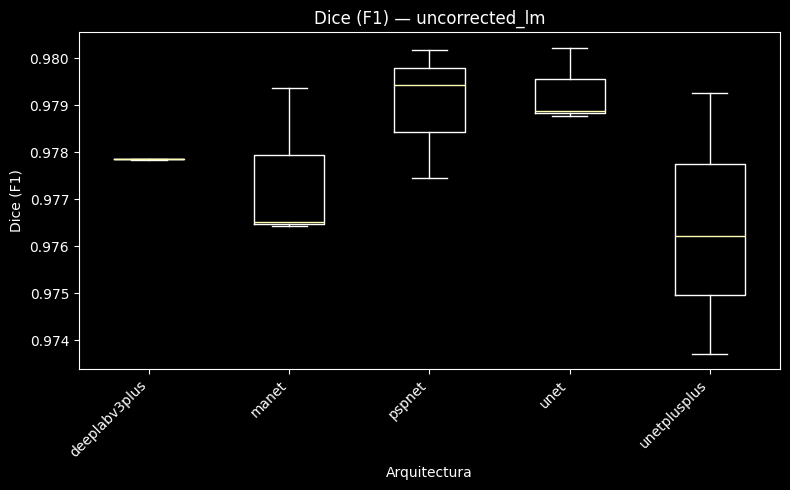

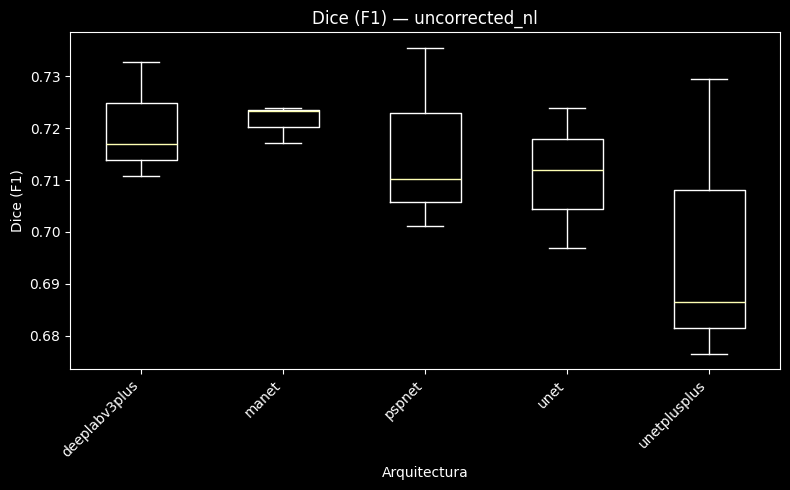

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# Load the CSV file
file_path = '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/first_year_exam/notebooks/wandb_labeled.csv'
df = pd.read_csv(file_path)

# 2) Extraer 'group', 'trial' y 'architecture'
def parse_name(name):
    parts = name.split('_')
    m = re.match(r'.*?experiment1_(.+?)_r\d+', name)
    group = m.group(1) if m else None
    trial = next((p for p in parts if re.match(r'^r\d+$', p)), None)
    arch = None
    if trial:
        idx = parts.index(trial)
        if idx + 1 < len(parts):
            arch = parts[idx + 1]
    return pd.Series([group, trial, arch], index=['group','trial','architecture'])

df[['group','trial','architecture']] = df['Name'].apply(parse_name)
df = df.dropna(subset=['group','trial','architecture'])

# 3) Quedarnos solo con la última época de cada corrida
df_last = (
    df
    .sort_values('epoch')
    .groupby(['group','architecture','trial'], as_index=False)
    .last()
)

# 4) Parámetros
groups        = sorted(df_last['group'].unique())
architectures = sorted(df_last['architecture'].unique())
metric_col    = 'valid_dataset_f1'  # Dice (F1)
metric_label  = 'Dice (F1)'

# 5) Para cada grupo, dibujar una figura con 5 boxplots
for group in groups:
    df_g = df_last[df_last['group'] == group]
    # preparar data y etiquetas
    data   = []
    labels = []
    for arch in architectures:
        vals = df_g[df_g['architecture']==arch][metric_col].values
        if len(vals) == 3:   # solo si tenemos r1,r2,r3
            data.append(vals)
            labels.append(arch)
    if not data:
        continue

    fig, ax = plt.subplots(figsize=(8,5))
    ax.boxplot(data, showfliers=False)
    ax.set_xticks(range(1, len(labels)+1))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xlabel('Arquitectura')
    ax.set_ylabel(metric_label)
    ax.set_title(f'{metric_label} — {group}')
    plt.tight_layout()
    plt.show()


In [7]:

# 2) Parse 'group', 'trial' and 'architecture'
def parse_name(name):
    parts = name.split('_')
    m = re.match(r'.*?experiment1_(.+?)_r\d+', name)
    group = m.group(1) if m else None
    trial = next((p for p in parts if re.match(r'^r\d+$', p)), None)
    arch = None
    if trial:
        idx = parts.index(trial)
        if idx + 1 < len(parts):
            arch = parts[idx + 1]
    return pd.Series([group, trial, arch], index=['group','trial','architecture'])

df[['group','trial','architecture']] = df['Name'].apply(parse_name)
df = df.dropna(subset=['group','trial','architecture'])

# 3) Keep only the last epoch per (group, arch, trial)
df_last = (
    df
    .sort_values('epoch')
    .groupby(['group','architecture','trial'], as_index=False)
    .last()
)

# 4) Boxplots in English labels
groups        = sorted(df_last['group'].unique())
architectures = sorted(df_last['architecture'].unique())


# 5) Summary table (mean ± std) for all metrics
metrics = {
    'Valid F1'       : 'valid_dataset_f1',
    'Test F1'        : 'test_dataset_f1',
    'Valid IoU'      : 'valid_dataset_iou',
    'Test IoU'       : 'test_dataset_iou',
    'Valid Accuracy' : 'valid_dataset_acc',
    'Test Accuracy'  : 'test_dataset_acc'
}

# Aggregate mean & std
agg_dict = {}
for name, col in metrics.items():
    agg_dict[f'{name} mean'] = (col, 'mean')
    agg_dict[f'{name} std']  = (col, 'std')

summary = (
    df_last
    .groupby(['group','architecture'])
    .agg(**agg_dict)
    .reset_index()
)

# Format "mean ± std"
for name in metrics:
    summary[name] = summary.apply(
        lambda r: f"{r[f'{name} mean']:.3f} ± {r[f'{name} std']:.3f}",
        axis=1
    )

# Keep only the final columns
summary = summary[['group','architecture'] + list(metrics.keys())]

#show summary as df with pandas
summary_df= pd.DataFrame(summary)
summary_df = summary_df.set_index(['group','architecture'])
summary_df = summary_df.rename_axis(index=['Group', 'Architecture'])

# Display the summary table
summary_df

Valid F1        Test F1  \
Group                        Architecture                                  
data_corrected_w_annotation  deeplabv3plus  0.670 ± 0.008  0.712 ± 0.017   
                             manet          0.672 ± 0.010  0.711 ± 0.009   
                             pspnet         0.670 ± 0.011  0.700 ± 0.020   
                             unet           0.667 ± 0.032  0.701 ± 0.019   
                             unetplusplus   0.679 ± 0.007  0.706 ± 0.007   
data_corrected_wo_annotation deeplabv3plus  0.563 ± 0.083  0.648 ± 0.080   
                             manet          0.669 ± 0.032  0.710 ± 0.025   
                             pspnet         0.571 ± 0.124  0.642 ± 0.091   
                             unet           0.590 ± 0.098  0.673 ± 0.073   
                             unetplusplus   0.656 ± 0.054  0.711 ± 0.041   
data_uncorrected             deeplabv3plus  0.716 ± 0.022  0.697 ± 0.056   
                             manet          0.744 ± 0.016  0.725 ± 0.028   
                             pspnet         0.727 ± 0.070  0.705 ± 0.055   
                             unet           0.756 ± 0.030  0.739 ± 0.013   
                             unetplusplus   0.724 ± 0.019  0.698 ± 0.014   
uncorrected_l                deeplabv3plus  0.821 ± 0.001  0.796 ± 0.008   
                             manet          0.821 ± 0.005  0.800 ± 0.009   
                             pspnet         0.816 ± 0.009  0.797 ± 0.009   
                             unet           0.819 ± 0.007  0.795 ± 0.011   
                             unetplusplus   0.818 ± 0.003  0.787 ± 0.004   
uncorrected_lb               deeplabv3plus  0.754 ± 0.010  0.874 ± 0.000   
                             manet          0.727 ± 0.030  0.869 ± 0.010   
                             pspnet         0.773 ± 0.011  0.875 ± 0.002   
                             unet           0.755 ± 0.014  0.869 ± 0.003   
                             unetplusplus   0.759 ± 0.027  0.858 ± 0.014   
uncorrected_lm               deeplabv3plus  0.978 ± 0.000  0.921 ± 0.001   
                             manet          0.977 ± 0.002  0.919 ± 0.004   
                             pspnet         0.979 ± 0.001  0.920 ± 0.003   
                             unet           0.979 ± 0.001  0.919 ± 0.003   
                             unetplusplus   0.976 ± 0.003  0.916 ± 0.001   
uncorrected_nl               deeplabv3plus  0.720 ± 0.011  0.621 ± 0.017   
                             manet          0.721 ± 0.004  0.620 ± 0.004   
                             pspnet         0.716 ± 0.018  0.618 ± 0.008   
                             unet           0.711 ± 0.014  0.619 ± 0.007   
                             unetplusplus   0.698 ± 0.028  0.605 ± 0.018   

                                                Valid IoU       Test IoU  \
Group                        Architecture                                  
data_corrected_w_annotation  deeplabv3plus  0.504 ± 0.009  0.553 ± 0.020   
                             manet          0.507 ± 0.011  0.553 ± 0.011   
                             pspnet         0.504 ± 0.013  0.539 ± 0.023   
                             unet           0.501 ± 0.035  0.540 ± 0.023   
                             unetplusplus   0.514 ± 0.008  0.546 ± 0.008   
data_corrected_wo_annotation deeplabv3plus  0.396 ± 0.078  0.485 ± 0.089   
                             manet          0.503 ± 0.037  0.554 ± 0.030   
                             pspnet         0.407 ± 0.123  0.479 ± 0.102   
                             unet           0.424 ± 0.101  0.512 ± 0.088   
                             unetplusplus   0.490 ± 0.060  0.558 ± 0.050   
data_uncorrected             deeplabv3plus  0.565 ± 0.023  0.538 ± 0.064   
                             manet          0.598 ± 0.018  0.571 ± 0.035   
                             pspnet         0.579 ± 0.084  0.546 ± 0.066   
                             unet           0.611 ± 0.037  0.587 ± 0.015   
                    

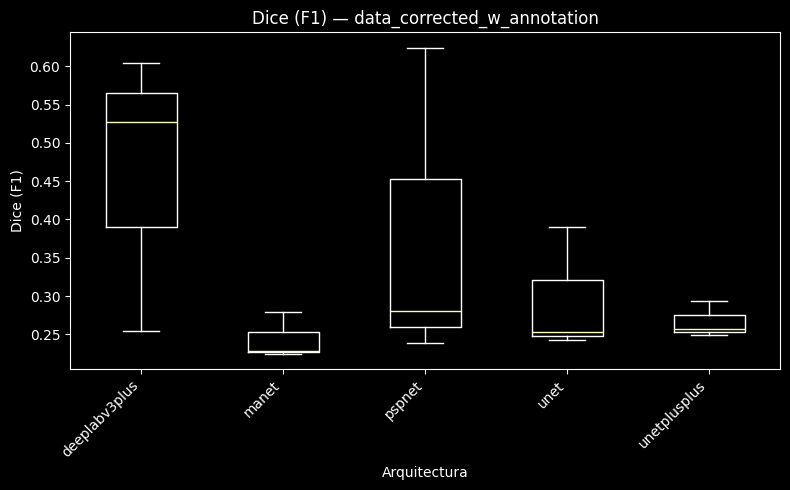

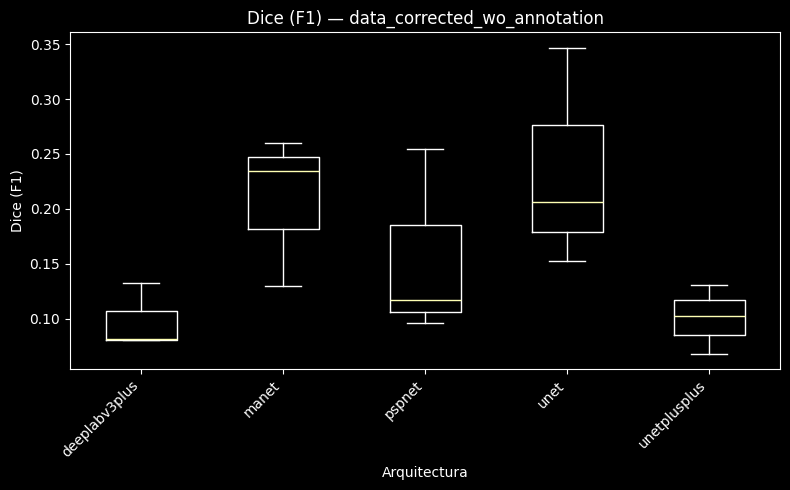

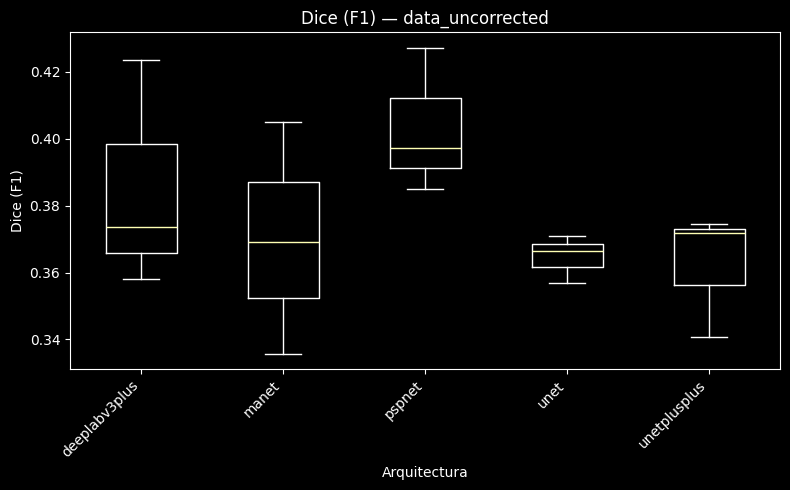

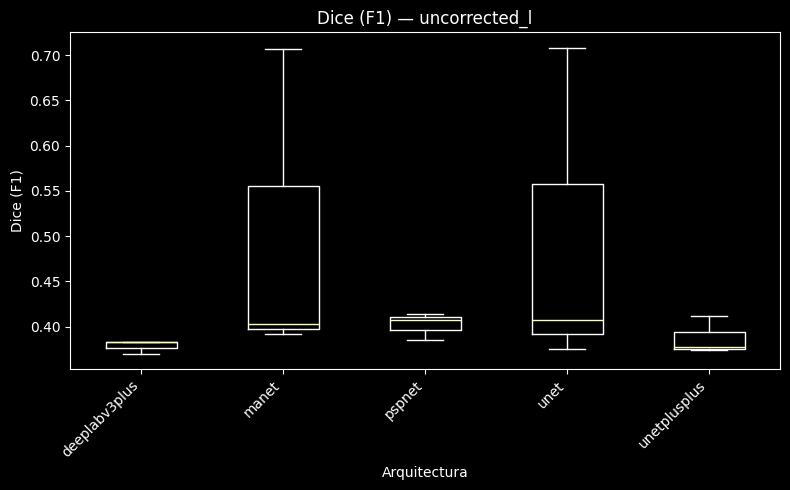

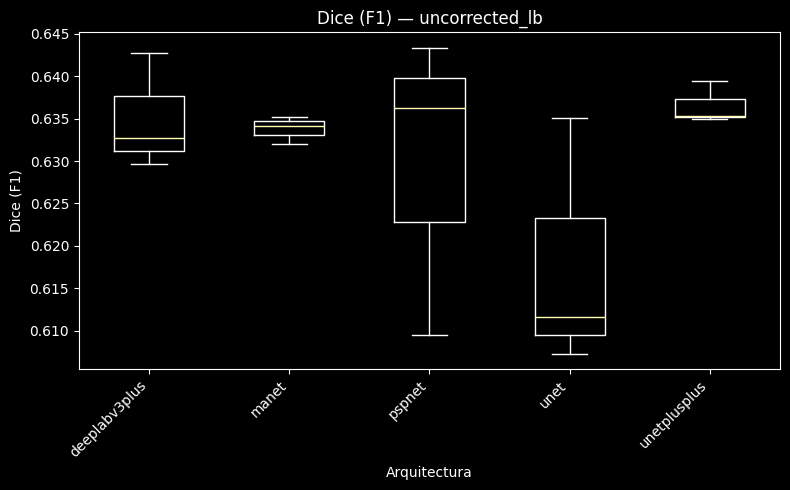

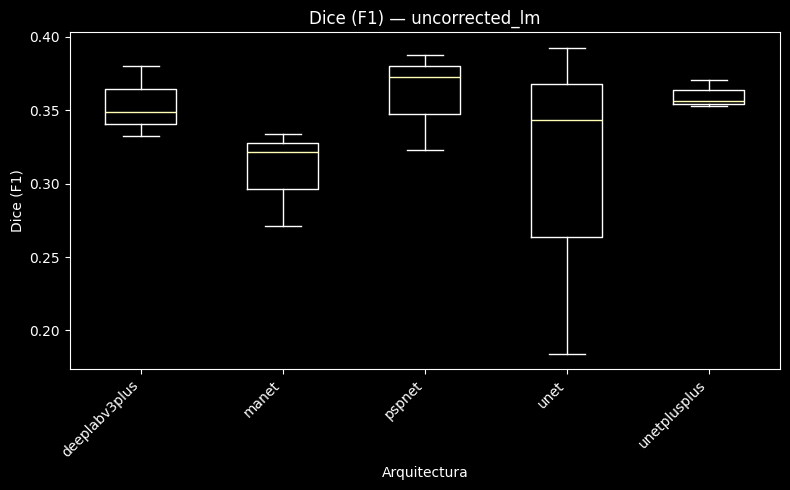

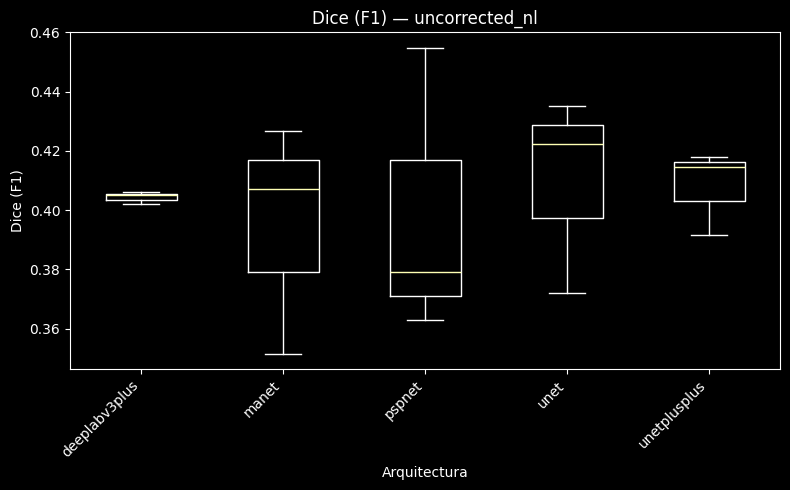

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# Load the CSV file
file_path = '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/first_year_exam/notebooks/wandb_unlabeled.csv'
df = pd.read_csv(file_path)

# 2) Extraer 'group', 'trial' y 'architecture'
def parse_name(name):
    parts = name.split('_')
    m = re.match(r'.*?experiment1_(.+?)_r\d+', name)
    group = m.group(1) if m else None
    trial = next((p for p in parts if re.match(r'^r\d+$', p)), None)
    arch = None
    if trial:
        idx = parts.index(trial)
        if idx + 1 < len(parts):
            arch = parts[idx + 1]
    return pd.Series([group, trial, arch], index=['group','trial','architecture'])

df[['group','trial','architecture']] = df['Name'].apply(parse_name)
df = df.dropna(subset=['group','trial','architecture'])

# 3) Quedarnos solo con la última época de cada corrida
df_last = (
    df
    .sort_values('epoch')
    .groupby(['group','architecture','trial'], as_index=False)
    .last()
)

# 4) Parámetros
groups        = sorted(df_last['group'].unique())
architectures = sorted(df_last['architecture'].unique())
metric_col    = 'valid_dataset_f1'  # Dice (F1)
metric_label  = 'Dice (F1)'

# 5) Para cada grupo, dibujar una figura con 5 boxplots
for group in groups:
    df_g = df_last[df_last['group'] == group]
    # preparar data y etiquetas
    data   = []
    labels = []
    for arch in architectures:
        vals = df_g[df_g['architecture']==arch][metric_col].values
        if len(vals) == 3:   # solo si tenemos r1,r2,r3
            data.append(vals)
            labels.append(arch)
    if not data:
        continue

    fig, ax = plt.subplots(figsize=(8,5))
    ax.boxplot(data, showfliers=False)
    ax.set_xticks(range(1, len(labels)+1))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xlabel('Arquitectura')
    ax.set_ylabel(metric_label)
    ax.set_title(f'{metric_label} — {group}')
    plt.tight_layout()
    plt.show()


In [9]:

# 2) Parse 'group', 'trial' and 'architecture'
def parse_name(name):
    parts = name.split('_')
    m = re.match(r'.*?experiment1_(.+?)_r\d+', name)
    group = m.group(1) if m else None
    trial = next((p for p in parts if re.match(r'^r\d+$', p)), None)
    arch = None
    if trial:
        idx = parts.index(trial)
        if idx + 1 < len(parts):
            arch = parts[idx + 1]
    return pd.Series([group, trial, arch], index=['group','trial','architecture'])

df[['group','trial','architecture']] = df['Name'].apply(parse_name)
df = df.dropna(subset=['group','trial','architecture'])

# 3) Keep only the last epoch per (group, arch, trial)
df_last = (
    df
    .sort_values('epoch')
    .groupby(['group','architecture','trial'], as_index=False)
    .last()
)

# 4) Boxplots in English labels
groups        = sorted(df_last['group'].unique())
architectures = sorted(df_last['architecture'].unique())


# 5) Summary table (mean ± std) for all metrics
metrics = {
    'Valid F1'       : 'valid_dataset_f1',
    'Test F1'        : 'test_dataset_f1',
    'Valid IoU'      : 'valid_dataset_iou',
    'Test IoU'       : 'test_dataset_iou',
    'Valid Accuracy' : 'valid_dataset_acc',
    'Test Accuracy'  : 'test_dataset_acc'
}

# Aggregate mean & std
agg_dict = {}
for name, col in metrics.items():
    agg_dict[f'{name} mean'] = (col, 'mean')
    agg_dict[f'{name} std']  = (col, 'std')

summary = (
    df_last
    .groupby(['group','architecture'])
    .agg(**agg_dict)
    .reset_index()
)

# Format "mean ± std"
for name in metrics:
    summary[name] = summary.apply(
        lambda r: f"{r[f'{name} mean']:.3f} ± {r[f'{name} std']:.3f}",
        axis=1
    )

# Keep only the final columns
summary = summary[['group','architecture'] + list(metrics.keys())]

#show summary as df with pandas
summary_df= pd.DataFrame(summary)
summary_df = summary_df.set_index(['group','architecture'])
summary_df = summary_df.rename_axis(index=['Group', 'Architecture'])

# Display the summary table
summary_df

Valid F1        Test F1  \
Group                        Architecture                                  
data_corrected_w_annotation  deeplabv3plus  0.462 ± 0.184  0.441 ± 0.187   
                             manet          0.244 ± 0.030  0.224 ± 0.016   
                             pspnet         0.381 ± 0.212  0.363 ± 0.205   
                             unet           0.295 ± 0.082  0.287 ± 0.099   
                             unetplusplus   0.267 ± 0.024  0.257 ± 0.034   
data_corrected_wo_annotation deeplabv3plus  0.098 ± 0.030  0.115 ± 0.023   
                             manet          0.208 ± 0.069  0.245 ± 0.073   
                             pspnet         0.156 ± 0.086  0.188 ± 0.121   
                             unet           0.235 ± 0.100  0.284 ± 0.096   
                             unetplusplus   0.101 ± 0.031  0.120 ± 0.033   
data_uncorrected             deeplabv3plus  0.385 ± 0.034  0.382 ± 0.028   
                             manet          0.370 ± 0.035  0.362 ± 0.028   
                             pspnet         0.403 ± 0.022  0.387 ± 0.012   
                             unet           0.365 ± 0.007  0.368 ± 0.007   
                             unetplusplus   0.362 ± 0.019  0.361 ± 0.018   
uncorrected_l                deeplabv3plus  0.379 ± 0.007  0.364 ± 0.012   
                             manet          0.501 ± 0.179  0.479 ± 0.154   
                             pspnet         0.402 ± 0.015  0.389 ± 0.022   
                             unet           0.497 ± 0.184  0.481 ± 0.156   
                             unetplusplus   0.387 ± 0.021  0.382 ± 0.031   
uncorrected_lb               deeplabv3plus  0.635 ± 0.007  0.720 ± 0.006   
                             manet          0.634 ± 0.002  0.695 ± 0.023   
                             pspnet         0.630 ± 0.018  0.720 ± 0.031   
                             unet           0.618 ± 0.015  0.697 ± 0.021   
                             unetplusplus   0.637 ± 0.002  0.722 ± 0.011   
uncorrected_lm               deeplabv3plus  0.354 ± 0.024  0.427 ± 0.026   
                             manet          0.309 ± 0.033  0.401 ± 0.035   
                             pspnet         0.361 ± 0.034  0.453 ± 0.032   
                             unet           0.307 ± 0.109  0.398 ± 0.116   
                             unetplusplus   0.360 ± 0.009  0.457 ± 0.015   
uncorrected_nl               deeplabv3plus  0.404 ± 0.002  0.430 ± 0.014   
                             manet          0.395 ± 0.039  0.435 ± 0.032   
                             pspnet         0.399 ± 0.049  0.428 ± 0.020   
                             unet           0.410 ± 0.033  0.407 ± 0.008   
                             unetplusplus   0.408 ± 0.014  0.439 ± 0.014   

                                                Valid IoU       Test IoU  \
Group                        Architecture                                  
data_corrected_w_annotation  deeplabv3plus  0.313 ± 0.150  0.295 ± 0.149   
                             manet          0.140 ± 0.020  0.126 ± 0.011   
                             pspnet         0.252 ± 0.176  0.236 ± 0.166   
                             unet           0.177 ± 0.060  0.171 ± 0.072   
                             unetplusplus   0.155 ± 0.016  0.148 ± 0.023   
data_corrected_wo_annotation deeplabv3plus  0.053 ± 0.017  0.062 ± 0.013   
                             manet          0.118 ± 0.043  0.142 ± 0.047   
                             pspnet         0.087 ± 0.052  0.108 ± 0.077   
                             unet           0.137 ± 0.066  0.169 ± 0.066   
                             unetplusplus   0.054 ± 0.018  0.065 ± 0.019   
data_uncorrected             deeplabv3plus  0.240 ± 0.026  0.237 ± 0.021   
                             manet          0.229 ± 0.026  0.221 ± 0.021   
                             pspnet         0.255 ± 0.017  0.240 ± 0.009   
                             unet           0.224 ± 0.006  0.225 ± 0.005   
                    